# Neural networks in human emotions - an overview, part 1.

Hello! In this notebook we will start exploring different structures of text classifier models and try to make sense of them. Our main constraint here is to try and work with different languages (hence the title, "human emotions").

In the second part of this project, we will analyze different architectures that are suitable for *sentiment* classification.

In [13]:
import numpy as np
import nltk
import sklearn
import pandas as pd
import torch

#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats()

The initial structure of the project is supposed to go like this:

1. Language classifier model - Here we classify the language of the input text. -- **this notebook!**
2. Translation of the text (optional) - If the original language of the text is not English, we try to make it English so that our model can be accurate in its predictions.
3. Classifying sentiment - Once the English version of the text is retrieved, be it the original one or translated, we try and classify it as one of the sentiments that is given to us in the dataset.

That being said, let's load the first dataset!

### Analyzing different datasets for language classifying

In [14]:
df1 = pd.read_csv(filepath_or_buffer='./archive.zip', compression='zip', encoding='utf-8')
df1.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


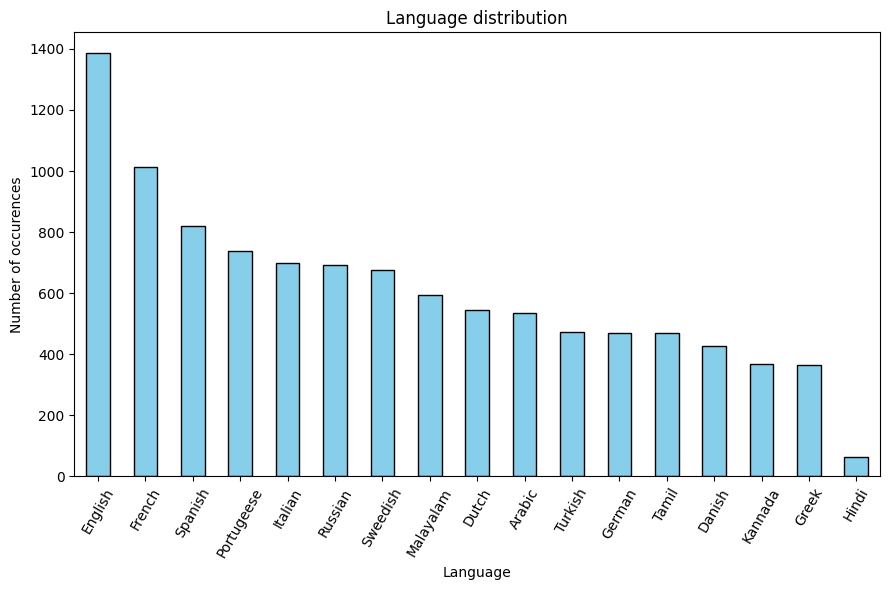

In [15]:
import matplotlib.pyplot as plt

language_count = df1['Language'].value_counts()
plt.figure(figsize=(9, 6))
language_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

We can see that besides the obvious fact that we are leaning more towards examples in English and French, the dataset contains only around 17 most spoken languages. However, "most spoken", in this case, is not an equivalent of "widely used". Take Serbian, for example. We will need to counter this problem.

That being said, let's take a look at the second dataset.

In [16]:
df2 = pd.read_csv(filepath_or_buffer='sentences.csv', encoding='utf-8')
df2.head()

,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [18]:
import json
languages = None
with open('lan_to_language.json') as language_data:
    languages = json.load(language_data)
    print('Type: ', type(languages))
print("Example: cmn")
print(languages['cmn'])

df2['language'] = df2['lan_code'].map(languages)

Type:  <class 'dict'>
Example: cmn
Mandarin Chinese


In [19]:
languages_unique = list()
def get_unique_languages(text):
    text = str(text)
    if text not in languages_unique:
        languages_unique.append(text)
    return languages_unique

In [20]:
df2['language'].map(get_unique_languages)
print("UNIQUE LANGUAGES: ", len(languages_unique))
df2.head()

UNIQUE LANGUAGES:  404


,id,lan_code,sentence,language
0,1,cmn,我們試試看！,Mandarin Chinese
1,2,cmn,我该去睡觉了。,Mandarin Chinese
2,3,cmn,你在干什麼啊？,Mandarin Chinese
3,4,cmn,這是什麼啊？,Mandarin Chinese
4,5,cmn,今天是６月１８号，也是Muiriel的生日！,Mandarin Chinese


404 unique languages in the dataset as opposed to 17 in the first one is, of course, a drastic change. Most likely, we will NOT need to classify so many languages.

Let's discard of the languages that have less than 10.000 samples in our dataset.

In [21]:
language_count = df2['language'].value_counts()
languages_to_keep = language_count[language_count >= 10000].index
df2_filtered = df2[df2['language'].isin(languages_to_keep)].copy()

languages_unique = list()

In [22]:
df2_filtered['language'].map(get_unique_languages)
print("UNIQUE LANGUAGES: ", len(languages_unique))
print("LANGUAGES LEFT: ")
print(sorted(languages_unique))
df2_filtered.head()

UNIQUE LANGUAGES:  48
LANGUAGES LEFT: 
['Arabic', 'Belarusian', 'Berber languages', 'Bulgarian', 'Central Kurdish', 'Czech', 'Danish', 'Dutch', 'English', 'Esperanto', 'Finnish', 'French', 'German', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Interlingua', 'Iranian Persian', 'Italian', 'Japanese', 'Kabyle', 'Klingon', 'Latin', 'Lingua Franca Nova', 'Lithuanian', 'Lojban', 'Low German', 'Macedonian', 'Mandarin Chinese', 'Marathi', 'Modern Greek (1453-)', 'Norwegian Bokmål', 'Polish', 'Portuguese', 'Romanian', 'Russian', 'Serbian', 'Slovak', 'Spanish', 'Swedish', 'Tagalog', 'Tatar', 'Toki Pona', 'Turkish', 'Ukrainian', 'Vietnamese']


,id,lan_code,sentence,language
0,1,cmn,我們試試看！,Mandarin Chinese
1,2,cmn,我该去睡觉了。,Mandarin Chinese
2,3,cmn,你在干什麼啊？,Mandarin Chinese
3,4,cmn,這是什麼啊？,Mandarin Chinese
4,5,cmn,今天是６月１８号，也是Muiriel的生日！,Mandarin Chinese


Now we can see that when we leave only the languages that have 10.000 or more samples in the dataset, we get 48 most spoken languages. Of course, outliers are still present (take Latin for example, not exactly a "most spoken" language), but overall the dataset got rid of unnecessary examples.

Let's look at the languages with the least amount of samples!

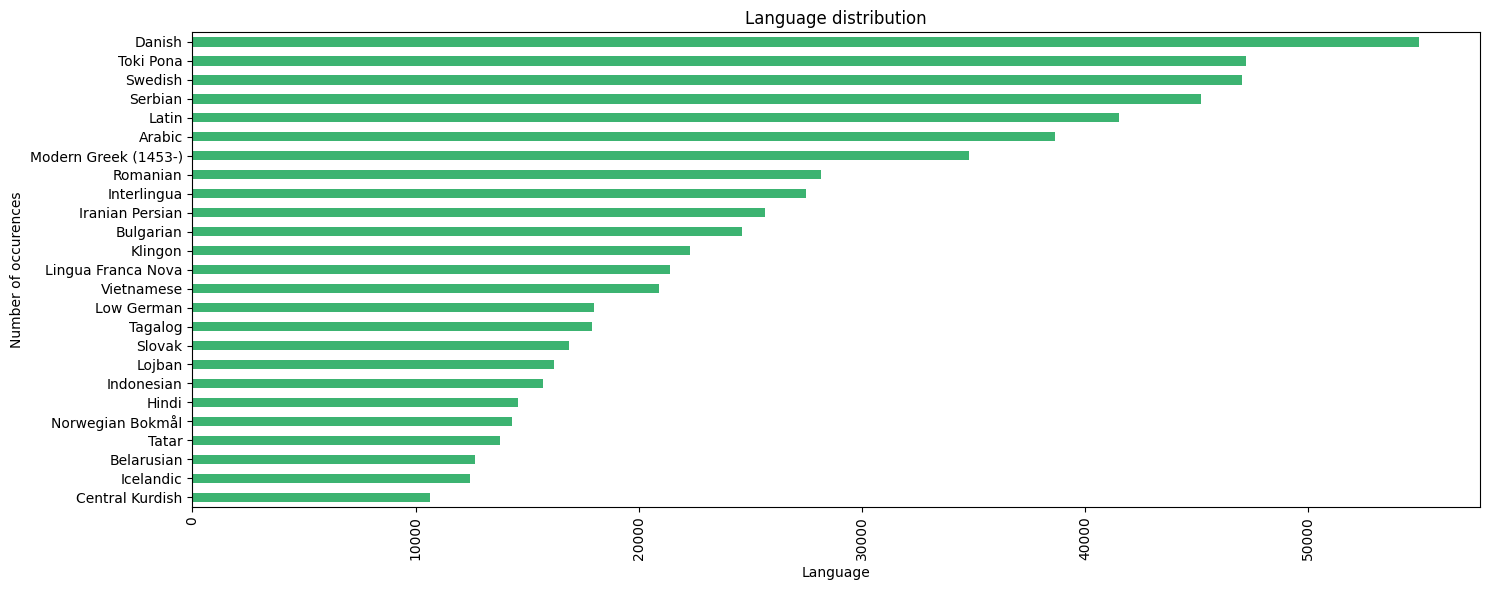

In [23]:
language_count = df2_filtered['language'].value_counts()
plt.figure(figsize=(15, 6))
language_count.tail(25).sort_values().plot(kind='barh', color='mediumseagreen')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Taking a look at the most underrepresented languages, everything seems fine. However, now let's take a look at the languages with the most samples in our dataset.

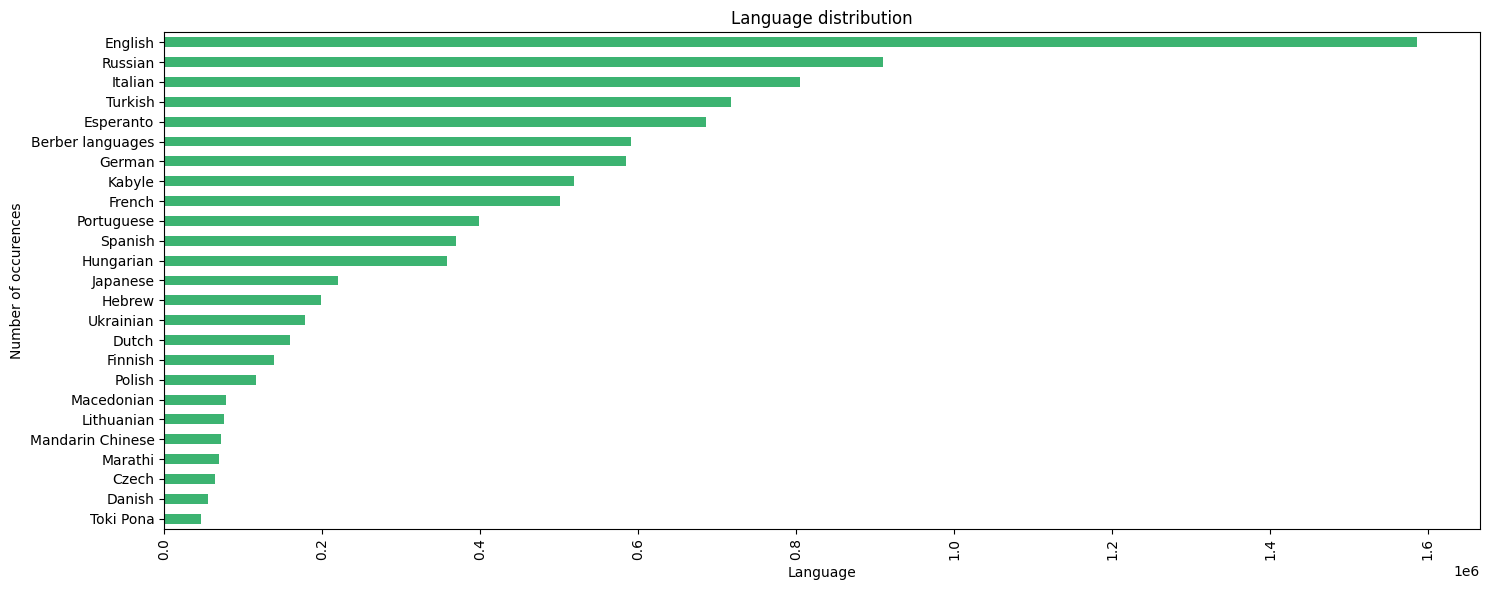

In [24]:
language_count = df2_filtered['language'].value_counts()
plt.figure(figsize=(15, 6))
language_count.head(25).sort_values().plot(kind='barh', color='mediumseagreen')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This is huge overrepresentation! English alone has 1.600.000 samples!

However, this is not as drastic as it might seem. Because our samples are single languages, we will need to concatenate them into longer paragraphs of 5-6 sentences. 

In [25]:
min_sentences = 5
max_sentences = 6

np.random.seed(42)

paragraphs = []

for lan_code, group in df2_filtered.groupby("lan_code"):

    group = group.sample(frac=1).reset_index(drop=True)

    sentences = group["sentence"].tolist()
    i = 0
    paragraph_id = 0
    while i < len(sentences) - min_sentences:
        n = np.random.randint(min_sentences, max_sentences + 1)
        if i + n > len(sentences):
            break
        paragraph = " ".join(sentences[i:i+n])
        paragraphs.append({
            "paragraph_id": f"{lan_code}_{paragraph_id}",
            "lan_code": lan_code,
            "language": group["language"].iloc[0],
            "paragraph_text": paragraph
        })
        i += n
        paragraph_id += 1

paragraph_df = pd.DataFrame(paragraphs)


paragraph_df.head()

,paragraph_id,lan_code,language,paragraph_text
0,ara_0,ara,Arabic,كان الكذب ينجّي ، الصدق أنجى وأنجى. سوف يكون ع...
1,ara_1,ara,Arabic,أنا العب مع أصحابي. سمعت ليلى صوتا مألوفا. أخذ...
2,ara_2,ara,Arabic,و أنت أيضا عقد حصّة. اصبح زيري مصلح كهرباء. أن...
3,ara_3,ara,Arabic,كن هادئاً وقت الدرس. أحتاج هذا العلاج. كلّ الم...
4,ara_4,ara,Arabic,أين يمكنني أن أجد سيارة أجرة؟ أرني ما لديك لطف...


In [26]:
paragraph_df.tail()

,paragraph_id,lan_code,language,paragraph_text
1825684,vie_3801,vie,Vietnamese,Con ở nhà bạn được không? Bob hỏi giáo viên mộ...
1825685,vie_3802,vie,Vietnamese,Tôi e rằng chúng ta không thể đi vào ngày thứ ...
1825686,vie_3803,vie,Vietnamese,Tom nháy mắt. Tại sao bạn lại khóc? Bạn cho và...
1825687,vie_3804,vie,Vietnamese,Tom không chắc là ông ta muốn làm cái điều này...
1825688,vie_3805,vie,Vietnamese,"Xin lỗi, ông có nói tiếng Anh không? Tôi có th..."


In [ ]:
# This code was used once. If you want to save the dataset, uncomment it.
#paragraph_df.to_csv("paragraph_language_dataset.csv", index=False)

Okay, now we have made each entry about 5 to 6 sentences long for data diversity.

Now let's see the distribution of samples for languages.

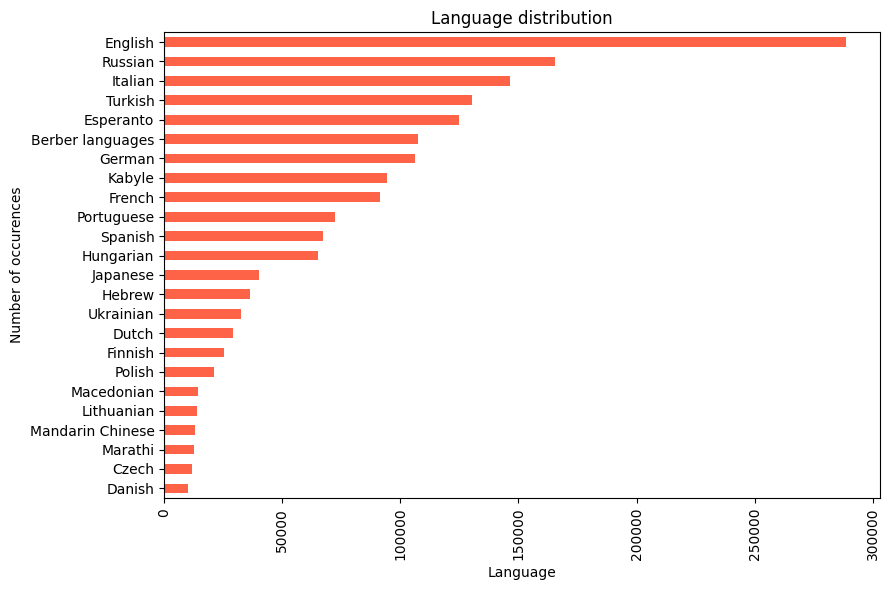

In [30]:
language_count = paragraph_df['language'].value_counts()
plt.figure(figsize=(9, 6))
language_count.head(24).sort_values().plot(kind='barh', color='tomato')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

As we can see, English is still the dominant language in our distribution, sitting at ~290.000 samples. Let's take a peek at the languages with the lowest count.

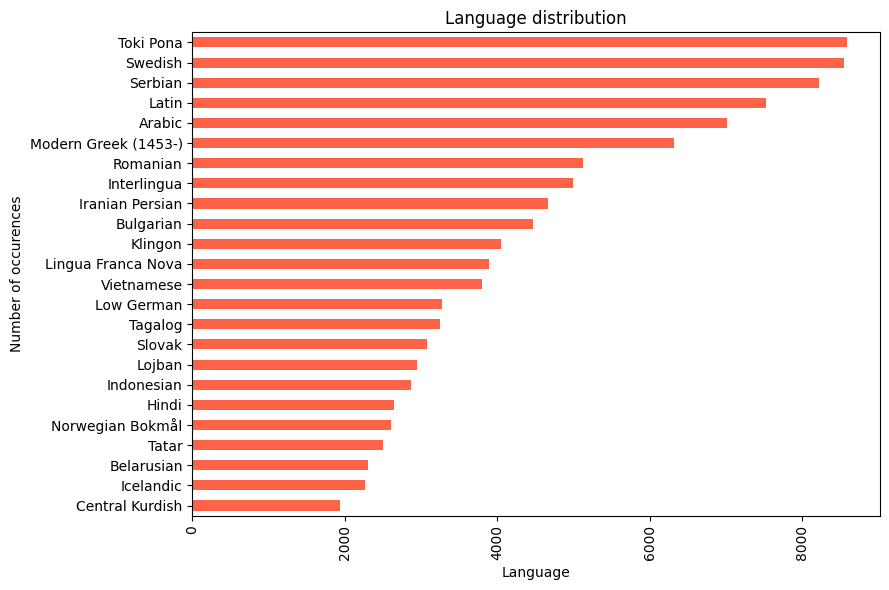

In [31]:
language_count = paragraph_df['language'].value_counts()
plt.figure(figsize=(9, 6))
language_count.tail(24).sort_values().plot(kind='barh', color='tomato')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The ratio of samples from the language with the smallest number of them with respect to the language with the biggest one is still **290.000 / 2000 = 145**. English is 145 times more represented than Central Kurdish.

This may **seem** right at first - Kurdish is simply not as popular of a language as English, but with *such* a gap all our model will learn is a huge bias towards the English language. Thus, we should still keep English as one of the dominant languages, but reduce the ratio between Kurdish and English. How? Capping!

With capping, we simply reduce the number of samples of every language that has more than 25.000 samples to 25.000 samples.

In [33]:
df_result = paragraph_df.groupby('language').apply(
    lambda x: x.sample(min(len(x), 25000), random_state=123)
).reset_index(drop=True)
df_result.tail()

,paragraph_id,lan_code,language,paragraph_text
628521,vie_1122,vie,Vietnamese,Viết bằng tay trái của bạn. Anh ấy thích làm t...
628522,vie_1346,vie,Vietnamese,Có một chuyện cổ tích về con mèo Ba Tư. Anh ta...
628523,vie_3454,vie,Vietnamese,Bài hát này quen thuộc đối với chúng tôi. Chún...
628524,vie_3437,vie,Vietnamese,Bà tôi có một gương mặt thuần phác. Thi đua là...
628525,vie_3582,vie,Vietnamese,Đây là ngôn ngữ khó học. Điều này thật sự rất ...


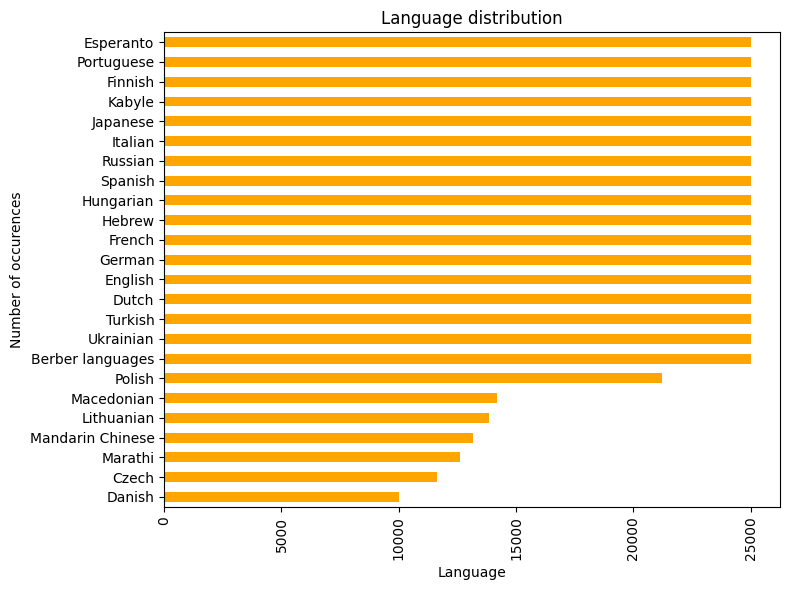

In [36]:
language_count = df_result['language'].value_counts()
plt.figure(figsize=(8, 6))
language_count.head(24).sort_values().plot(kind='barh', color='orange')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

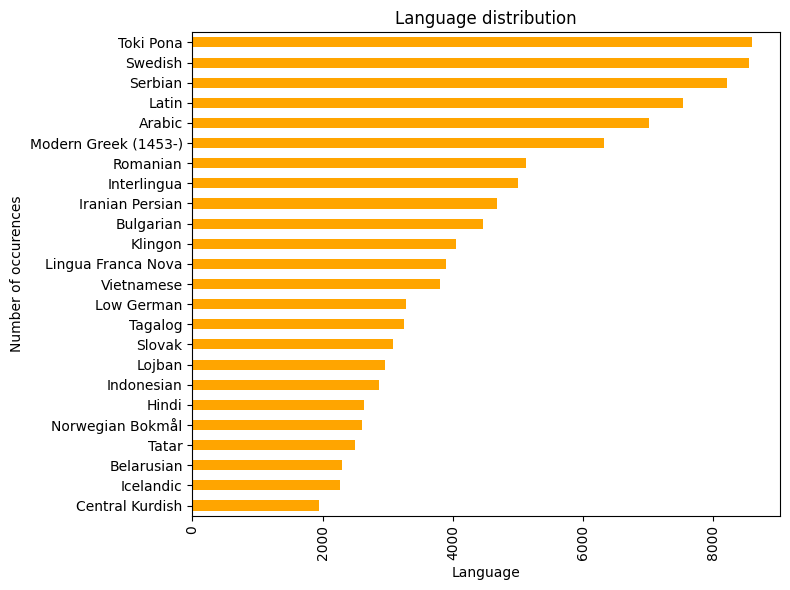

In [38]:
language_count = df_result['language'].value_counts()
plt.figure(figsize=(8, 6))
language_count.tail(24).sort_values().plot(kind='barh', color='orange')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This is exactly what we have expected with our analysis. Now the ratio of English/Kurdish (max/min) is 12.5 (as opposed to 145)!

Now, it is worth noting that this is still not ideal. The ratio is still quite big, even if it is significantly reduced from 145 to 12.5. However, aside from data augmentation, there is not much that we can do to promote diversity for smaller languages and to reduce the ratio, because if we try and cap the data at an even smaller point, that will lead to even more drastic changes in our dataset. Right now, the dataset stands at 628.525 entries (as opposed to the original 10.341.811), and capping it will lead to even more data loss from the dataset.

Right now, we have a solid ground to train a working model without the help of professional linguists at our side to label the data.


In [20]:
def to_lowercase(text):
    text = str(text)
    return text.lower()

In [21]:
df_result['language'] = df_result['language'].map(to_lowercase)
df_result['paragraph_text'] = df_result['paragraph_text'].map(to_lowercase)

df_result.head()

,paragraph_id,lan_code,language,paragraph_text
0,ara_3845,ara,arabic,كان من طبيعتها أنها فتاة خجولة جداً. كنت في لن...
1,ara_4147,ara,arabic,لا أحد يريد الذهاب إلى هناك. طولُك مثل طولي. ت...
2,ara_6375,ara,arabic,هناك شوكة ناقصة. أيمكنك ملاحظة الفرق؟ توم رجل ...
3,ara_5928,ara,arabic,لقد حدث هذا منذ زمن طويل. كانت تريد ليلى أن تس...
4,ara_5249,ara,arabic,توم يرفض أن يفعل أي شيء غير أخلاقي مع ماري. لا...


### Building the first model for language classification.

#### Naive Bayes - the baseline.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

print(df_result.isnull().sum())

x = np.array(df_result['paragraph_text'])
y = np.array(df_result['language'])

count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print("Entries for training: ", x_train.shape)
print("Entries for testing: ", x_test.shape)

paragraph_id      0
lan_code          0
language          0
paragraph_text    0
dtype: int64
Entries for training:  (502820, 1388261)
Entries for testing:  (125706, 1388261)


In [69]:
import joblib
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

modelNBBOW = MultinomialNB()
modelNBBOW.fit(x_train, y_train)

y_pred = modelNBBOW.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

                      precision    recall  f1-score   support

              arabic       1.00      1.00      1.00      1453
          belarusian       1.00      1.00      1.00       443
    berber languages       0.99      1.00      1.00      5099
           bulgarian       1.00      1.00      1.00       879
     central kurdish       1.00      1.00      1.00       370
               czech       1.00      1.00      1.00      2338
              danish       0.92      1.00      0.96      1942
               dutch       1.00      1.00      1.00      5032
             english       1.00      1.00      1.00      4867
           esperanto       1.00      1.00      1.00      5039
             finnish       1.00      1.00      1.00      5135
              french       1.00      1.00      1.00      5019
              german       1.00      1.00      1.00      4959
              hebrew       1.00      1.00      1.00      5028
               hindi       1.00      0.96      0.98       486
       

In [ ]:
manual_testing_strings = ["Danas je bio veoma lep dan. Sunce je sijalo tokom celog jutra, a uveče smo otišli u šetnju kraj reke. Deca su se igrala u parku dok su roditelji razgovarali. U prodavnici sam kupio sve što nam je trebalo za večeru. Sutra planiramo da idemo kod bake i deke na ručak.",
                          "Сегодня был очень хороший день. Солнце светило ярко, и мы решили прогуляться в парке. Ветер был лёгкий, и воздух казался особенно свежим. Мы зашли в кафе и выпили по чашке кофе. Завтра я собираюсь навестить своих родителей",
                          "Dnes bolo krásne počasie, a tak sme sa rozhodli ísť na výlet. Navštívili sme malé mestečko neďaleko nášho domova. Deti sa tešili na zmrzlinu a jazdu na bicykli. Cestou späť sme sa zastavili v kníhkupectve. Večer sme strávili pri spoločnej večeri.",
                          "Danes je bil čudovit dan. Odpravili smo se na sprehod po gozdu in opazovali ptice. Vzeli smo s seboj malico in uživali v naravi. Otroci so tekali po travniku in se smejali. Na poti domov smo kupili sveže sadje na tržnici.",
                          "Dnes bylo opravdu hezky, a tak jsme šli ven na procházku. This is an English sentence. Navštívili jsme místní park, kde kvetly první jarní květiny. Děti si hrály na hřišti, zatímco jsme si povídali na lavičce. Po cestě domů jsme se zastavili v pekárně. Večer jsme si pustili film a odpočívali."]
manual_testing_labels = ['Serbian', 'Russian', 'Slovak', 'Slovenian', 'Czech']
manual_testing_predictions = list()

for text in manual_testing_strings:
    output = modelNBBOW.predict(count_vectorizer.transform([text]).toarray())
    manual_testing_predictions.append(output)

print(manual_testing_predictions)

[array(['serbian'], dtype='<U20'), array(['russian'], dtype='<U20'), array(['slovak'], dtype='<U20'), array(['serbian'], dtype='<U20'), array(['czech'], dtype='<U20')]


As we can see, the model that was intended for us as a baseline - Naive Bayes - is doing pretty well in terms of accuracy. The only mistake it made was classifying Slovenian as Serbian - however, Slovenian was not in the dataset, which means that this error was expected.

With the Czech example, we can also see that it generalizes the language - meaning that if we have 5 sentences in one language and 1 in another, the predicted language is still Czech.

**However**, we still should experiment with a couple of different approaches to see if we get better results, even if this accuracy seems great already.

#### 1D Convolutional Neural Network.

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

print(torch.get_autocast_gpu_dtype())
print(df_result.isna().sum())

torch.float16
paragraph_id      0
lan_code          0
language          0
paragraph_text    0
language_id       0
dtype: int64


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda'

class LanguageClassifierCNN(nn.Module):
    def __init__(self, vocabulary_dim, num_languages):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_dim, 100)
        self.conv1 = nn.Conv1d(100, 256, 7)
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=128)
        self.conv2 = nn.Conv1d(256, 128, 5)
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=64)
        self.conv3 = nn.Conv1d(128, 64, 3)
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=32)

        self.fc1 = nn.Linear(in_features=(32 * 64), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_languages)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [27]:
tokens = list()
tokens.append("UNK")
tokens.append("PAD")
for item in list(count_vectorizer.vocabulary_):
    tokens.append(item)
token_to_id = {token: id for id, token in enumerate(tokens)}
print("VOCABULARY LENGTH: ", len(list(token_to_id)))
print()
print("SAMPLE ID OF PAD: ", token_to_id['PAD'])

VOCABULARY LENGTH:  1388263

SAMPLE ID OF PAD:  1


In [28]:
model = LanguageClassifierCNN(len(tokens), 48).to(device)

In [29]:
UNK_IX, PAD_IX = map(token_to_id.get, ["UNK", "PAD"])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [30]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key == 'paragraph_text' or key == 'language':
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

In [31]:
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop]).astype(np.float32)
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [32]:
def make_batch(data, max_len=None, word_dropout=0, device=device):
    batch = {}
    batch['paragraph_text'] = as_matrix(data['paragraph_text'].values, max_len)

    if word_dropout != 0:
        batch['paragraph_text'] = apply_word_dropout(batch['paragraph_text'], 1. - word_dropout)
    
    if 'language_id' in data.columns:
        batch['language'] = data['language_id'].values
    return to_tensors(batch, device)

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_result['language_id'] = le.fit_transform(df_result['language'])

data_train, data_test = train_test_split(df_result, test_size=0.2)
make_batch(data_train[:3], max_len=10)
print(df_result['language_id'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


In [34]:
print(f"LabelEncoder classes: {le.classes_} (len: {len(le.classes_)})")

LabelEncoder classes: ['arabic' 'belarusian' 'berber languages' 'bulgarian' 'central kurdish'
 'czech' 'danish' 'dutch' 'english' 'esperanto' 'finnish' 'french'
 'german' 'hebrew' 'hindi' 'hungarian' 'icelandic' 'indonesian'
 'interlingua' 'iranian persian' 'italian' 'japanese' 'kabyle' 'klingon'
 'latin' 'lingua franca nova' 'lithuanian' 'lojban' 'low german'
 'macedonian' 'mandarin chinese' 'marathi' 'modern greek (1453-)'
 'norwegian bokmål' 'polish' 'portuguese' 'romanian' 'russian' 'serbian'
 'slovak' 'spanish' 'swedish' 'tagalog' 'tatar' 'toki pona' 'turkish'
 'ukrainian' 'vietnamese'] (len: 48)


Great! Our methods work. Let's try and make a prediction.

In [35]:
batch = make_batch(data_train[:100], device=device)
criterion = nn.CrossEntropyLoss()
print(list(batch))

prediction = model(batch['paragraph_text'])
print(prediction.shape)
print(batch['language'])
loss = criterion(prediction, batch['language'])

['paragraph_text', 'language']
torch.Size([100, 48])
tensor([12, 46,  9, 46, 21, 12, 35, 46, 10,  2, 24, 29,  8,  9, 40,  7, 28, 44,
         9, 45, 20, 46, 40, 11,  2, 21, 45, 31, 25, 40, 11, 36, 38, 30, 13, 11,
         0, 12, 11, 21,  2,  2, 44, 15, 40, 40, 12, 12, 20, 13, 11, 21, 26,  7,
        21,  5,  8, 26,  2, 26, 19, 45, 46, 24, 34,  9, 21, 21, 29, 29,  2, 37,
        21, 30, 40,  2, 15, 16, 21, 45, 40,  2, 24, 46,  5, 10, 11, 24, 31, 36,
        20, 21, 15, 13,  9, 45, 45,  8, 38, 46], device='cuda:0')


Awesome, the prediction function works and is set up correctly. Now let's train and test the model.

In [36]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)
            

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [37]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [62]:
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
import warnings
from tqdm.std import TqdmWarning
warnings.filterwarnings('ignore', category=TqdmWarning)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
batch_size = 128

total_accuracy = list()
total_loss = list()
scaler = GradScaler()


In [39]:
for epoch in range(epochs):
    total_correct = 0
    total_examples = 0
    total_loss_epoch = 0
    print(f"epoch: ", {epoch})
    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size, device=device)), total=len(data_train) // batch_size):
        optimizer.zero_grad()
        targets = batch['language']
        with autocast(device_type=device):
            logits = model(batch['paragraph_text'])
            loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    

        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).sum().item()
        total_loss_epoch += loss.item()
        total_correct = total_correct + correct
        total_examples += targets.size(0)
    
    epoch_loss = total_loss_epoch / total_examples
    epoch_accuracy = total_correct / total_examples
    total_loss.append(total_loss_epoch)
    total_accuracy.append(epoch_accuracy)
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

epoch:  {0}


3929it [02:08, 30.60it/s]                          


Epoch 1: Loss = 0.0031, Accuracy = 0.8715
epoch:  {1}


3929it [02:06, 31.03it/s]                          


Epoch 2: Loss = 0.0006, Accuracy = 0.9687
epoch:  {2}


3929it [02:06, 30.99it/s]                          


Epoch 3: Loss = 0.0005, Accuracy = 0.9747
epoch:  {3}


3929it [02:06, 31.04it/s]                          


Epoch 4: Loss = 0.0004, Accuracy = 0.9762
epoch:  {4}


3929it [02:06, 31.09it/s]                          

Epoch 5: Loss = 0.0004, Accuracy = 0.9777


Great, we get a total accuracy of ~0.97 during training. Let's plot those values on a graph for easier visualization.

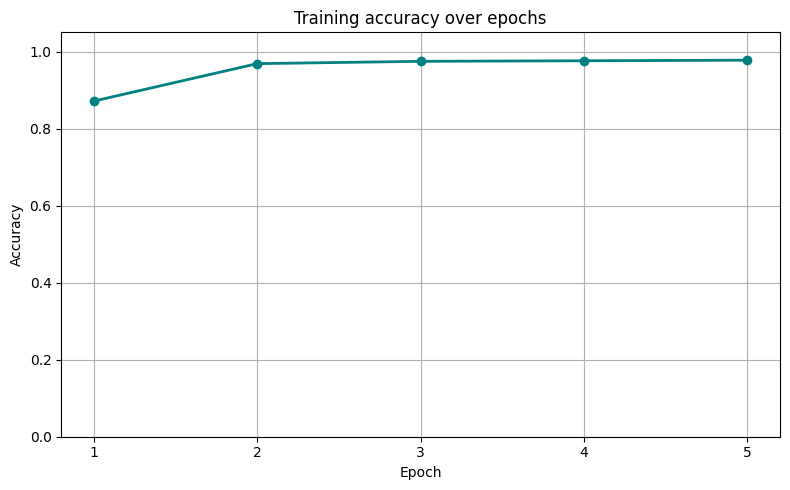

In [40]:
epochs_range = range(1, len(total_accuracy) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, total_accuracy, marker='o', color='teal', linestyle='-', linewidth=2)
plt.title('Training accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

We can clearly see the accuracy stalling after the second epoch - we should not add more as it would lead to overfitting. Let's test the model on the test data and mark down the results.

In [41]:
print(len(data_test))

125706


In [42]:
model.eval()
test_correct = 0
test_examples = 0
with torch.no_grad():
    for i, batch in tqdm(enumerate(iterate_minibatches(data_test, batch_size, device=device)), total=len(data_test) // batch_size):
        out_data = model(batch['paragraph_text'])
        targets = batch['language']
        predictions = torch.argmax(out_data, dim=1)

        test_correct += (predictions == targets).sum().item()
        test_examples += targets.size(0)

test_accuracy = test_correct / test_examples
print("Test accuracy: ", test_accuracy)


983it [00:05, 178.73it/s]                         

Test accuracy:  0.974973350516284


Awesome! The accuracy of the model is close to training.

However, we might notice one drawback: the model's accuracy is 0.97, while the accuracy of Naive Bayes was 0.98. This might not seem so drastic, but with more computations we have achieved a worse result. Of course, not significantly worse, but certainly not better. Let's experiment a bit further with different architectures. If nothing works - we have Naive Bayes, but if something does - we'll use that!

#### LSTM Reccurent Neural Network

Now we are going into the "a little bit overkill" territory - fun to build and experiment, but just a bit **too** sophisticated for the task at hand. You might ask - "Is there such thing as making a solution too sophisticated?", and I'll answer - "Yes!"

LSTMs are designed to counter the exploding/disappearing gradient problem which appears when we try and analyze text through a vanilla RNN. However, we do not have to use an RNN in our case. This is because for language classification tasks, like the one we have right now, the meaning of the words and the sentences often does not carry the same weight as the language features - mostly characters and words.

However, this does **not** mean that we shouldn't try, of course not! Let's try and see if there is anything useful that might come out of this, we will have to experiment with LSTMs, attention and transformers further in this project anyway.

In [43]:
class LanguageClassifierRNN(nn.Module):
    def __init__(self, vocabulary_dimention, num_languages, hidden_dim, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocabulary_dimention, 100)
        self.lstm = nn.LSTM(100, hidden_size=hidden_dim, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_languages)
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        _, (h_n, _) = self.lstm(x)
        final_hidden = h_n[-1]
        out = self.fc(final_hidden)
        return out

In [44]:
from torch.amp import autocast, GradScaler
model_rnn = LanguageClassifierRNN(len(tokens), num_languages=48, hidden_dim=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)

epochs = 5
batch_size = 128

total_accuracy = list()
total_loss = list()
scaler = GradScaler()

In [46]:
from tqdm.auto import tqdm
for epoch in range(epochs):
    total_correct = 0
    total_examples = 0
    total_loss_epoch = 0
    print(f"epoch: ", {epoch})
    model_rnn.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size, device=device)), total=len(data_train) // batch_size):
        optimizer.zero_grad()
        targets = batch['language']
        with autocast(device_type=device):
            logits = model_rnn(batch['paragraph_text'])
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).sum().item()
        total_loss_epoch += loss.item()
        total_correct = total_correct + correct
        total_examples += targets.size(0)
    
    epoch_loss = total_loss_epoch / total_examples
    epoch_accuracy = total_correct / total_examples
    total_loss.append(total_loss_epoch)
    total_accuracy.append(epoch_accuracy)
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

epoch:  {0}


3929it [02:01, 32.42it/s]                          


Epoch 1: Loss = 0.0018, Accuracy = 0.9266
epoch:  {1}


3929it [02:00, 32.63it/s]                          


Epoch 2: Loss = 0.0005, Accuracy = 0.9735
epoch:  {2}


3929it [02:00, 32.53it/s]                          


Epoch 3: Loss = 0.0004, Accuracy = 0.9775
epoch:  {3}


3929it [02:00, 32.52it/s]                          


Epoch 4: Loss = 0.0003, Accuracy = 0.9789
epoch:  {4}


3929it [02:00, 32.48it/s]                          

Epoch 5: Loss = 0.0003, Accuracy = 0.9794


After around 10 minutes of training, we get an accuracy that is **very** close to 0.98 (0.9795). However, the great accuracy does not cancel out the fact that this is still just a tiny bit worse than Naive Bayes. Aside from that, we also can see the accuracy stalling after the second epoch. Let's evaluate!

In [47]:
model_rnn.eval()
test_correct = 0
test_examples = 0
with torch.no_grad():
    for i, batch in tqdm(enumerate(iterate_minibatches(data_test, batch_size, device=device)), total=len(data_test) // batch_size):
        out_data = model_rnn(batch['paragraph_text'])
        targets = batch['language']
        predictions = torch.argmax(out_data, dim=1)

        test_correct += (predictions == targets).sum().item()
        test_examples += targets.size(0)

test_accuracy = test_correct / test_examples
print("Test accuracy: ", test_accuracy)

983it [00:04, 196.72it/s]                         

Test accuracy:  0.9759438690277313


The result is quite strong.

The last model that we are going to build and try in this notebook is going to be something a bit simpler than a CNN, but a bit more sophisticated than a simple Naive Bayes: Naive Bayes with TF-IDF!

#### Naive Bayes - TF-IDF.

**Why are we trying this?** - The answer is quite simple: as mentioned before, while we care about the complicated things like position of the words and their relationship, we do not care about them *that much*. What we do need to care about are the simples linguistic features: word choice, jargon, slang.

And that's just what Naive Bayes gives us! It works under the assumption called Bag of Words, which basically means that the algorithm assumes that the words do not have any relationship with each other, and that the use of one word in a sentence does not indicate the use of any other.

Of course, the sentence structure can *help* us in classifying language, but is it really worth the difference in complexity that we observe between Naive Bayes and LSTM RNNs? I do not think so, but...

...**there is a better thing than a Bag of Words!**

It's called TF-IDF (Term Frequency - Inverse Document Frequency). This helps us not make assumptions solely on BoW, but on the importance of a word in a document relative to the corpus (in our case, the importance of a word in a paragraph based to all the paragraphs in the testing data)

However, as any tool, it has its use cases, and might not suit us. Let's build it and check if it performs better!

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

x = np.array(df_result['paragraph_text'])
y = np.array(df_result['language'])

tf_idf_vec = TfidfVectorizer()
X = tf_idf_vec.fit_transform(raw_documents=x)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print("Entries for training: ", x_train.shape)
print("Entries for testing: ", x_test.shape)

Entries for training:  (502820, 1388261)
Entries for testing:  (125706, 1388261)


In [49]:
modelNB = MultinomialNB()
modelNB.fit(x_train, y_train)

y_pred = modelNB.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

                      precision    recall  f1-score   support

              arabic       1.00      1.00      1.00      1453
          belarusian       1.00      0.89      0.94       443
    berber languages       0.99      1.00      1.00      5099
           bulgarian       1.00      0.99      0.99       879
     central kurdish       1.00      1.00      1.00       370
               czech       0.98      1.00      0.99      2338
              danish       0.81      1.00      0.90      1942
               dutch       1.00      1.00      1.00      5032
             english       1.00      1.00      1.00      4867
           esperanto       1.00      1.00      1.00      5039
             finnish       1.00      1.00      1.00      5135
              french       1.00      1.00      1.00      5019
              german       1.00      1.00      1.00      4959
              hebrew       1.00      1.00      1.00      5028
               hindi       1.00      0.84      0.91       486
       

Oh no! This performs worse than Naive Bayes with a BoW!

Let's not panic, there is an explanation for this.

TF-IDF, if we break it down into two parts, looks like this:



**TF = (number of times term t appears in a documend d)/(number of terms in document d)**

**IDF = log((number of documents in corpus C)/(number of documents containing term t))**



This structure, when multiplied, can help "normalize" the frequencies of words appearing. This means that the weights of the most frequent words in the document will be downsized, and the weights of the least frequent words - upsized. This works well in classification tasks, however, not in ours.

Why? Take a look at this table.

|   Word   | Frequency in English | Frequency in French | IDF  |
|----------|----------------------|---------------------|------|
| "the"    | Very high            | Zero                | Low  |
| "le"     | Zero                 | Very high           | Low  |

TF-IDF downweights *both* words, even though they are absolutely perfect for our case! This leads to "softening" our weights for the words, which leads to underperforming. This is because, even if the word "le" appears only in French paragraphs, we still have 25.000 of those paragraphs! All of the most frequent words get downweighted, but they are perfect language indicators.

But this is not all! Naive Bayes *relies* on word counts, meaning that with BoW, when it gets the value 10, it knows that the word has been spotted 10 times in the text. However, when it gets the weight value 0.32, it gets lost.

Let's try something else!

In [50]:
from sklearn.linear_model import LogisticRegression
modelLR = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000)
modelLR.fit(x_train, y_train)

y_pred = modelLR.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

                      precision    recall  f1-score   support

              arabic       1.00      0.98      0.99      1453
          belarusian       1.00      0.95      0.97       443
    berber languages       0.99      0.99      0.99      5099
           bulgarian       1.00      1.00      1.00       879
     central kurdish       1.00      0.94      0.97       370
               czech       1.00      1.00      1.00      2338
              danish       0.99      1.00      0.99      1942
               dutch       1.00      1.00      1.00      5032
             english       1.00      1.00      1.00      4867
           esperanto       1.00      1.00      1.00      5039
             finnish       1.00      1.00      1.00      5135
              french       1.00      1.00      1.00      5019
              german       1.00      1.00      1.00      4959
              hebrew       1.00      1.00      1.00      5028
               hindi       1.00      0.98      0.99       486
       

Logistic Regression with TF-IDF performs just the same as the Naive Bayes model! And just for the same reasons.

Now, for the record, we are not going to be training Logistic Regression on BoW. This is due to the fact that BoW often has more values and training the model would take a huge amount of time, especially since all of the calculations are going to be performed on the CPU. What we will train instead is Stochastic Gradient Descent with a log loss function to mimick Logistic Regression.

In [54]:
from sklearn.linear_model import SGDClassifier
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
modelSGD = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
modelSGD.fit(x_train, y_train)

y_pred = modelSGD.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

                      precision    recall  f1-score   support

              arabic       1.00      0.86      0.92      1453
          belarusian       0.00      0.00      0.00       443
    berber languages       0.95      0.96      0.96      5099
           bulgarian       1.00      0.53      0.69       879
     central kurdish       1.00      0.01      0.02       370
               czech       0.89      0.97      0.93      2338
              danish       0.79      1.00      0.88      1942
               dutch       0.98      1.00      0.99      5032
             english       1.00      1.00      1.00      4867
           esperanto       1.00      1.00      1.00      5039
             finnish       0.99      0.99      0.99      5135
              french       1.00      1.00      1.00      5019
              german       1.00      1.00      1.00      4959
              hebrew       1.00      1.00      1.00      5028
               hindi       1.00      0.77      0.87       486
       

As expected, we get questionable accuracy with TF-IDF...

In [55]:
x = np.array(df_result['paragraph_text'])
y = np.array(df_result['language'])

X = count_vectorizer.fit_transform(raw_documents=x)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print("Entries for training: ", x_train.shape)
print("Entries for testing: ", x_test.shape)

Entries for training:  (502820, 1388261)
Entries for testing:  (125706, 1388261)


In [56]:
modelSGD = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
modelSGD.fit(x_train, y_train)

y_pred = modelSGD.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

                      precision    recall  f1-score   support

              arabic       1.00      0.98      0.99      1453
          belarusian       1.00      0.94      0.97       443
    berber languages       0.98      0.98      0.98      5099
           bulgarian       1.00      0.99      1.00       879
     central kurdish       1.00      0.95      0.97       370
               czech       1.00      1.00      1.00      2338
              danish       0.98      1.00      0.99      1942
               dutch       1.00      1.00      1.00      5032
             english       1.00      1.00      1.00      4867
           esperanto       1.00      1.00      1.00      5039
             finnish       1.00      1.00      1.00      5135
              french       1.00      1.00      1.00      5019
              german       1.00      1.00      1.00      4959
              hebrew       1.00      1.00      1.00      5028
               hindi       1.00      0.98      0.99       486
       

And some pretty nice accuracy with the BoW!

During all of this, it is possible that it might have sounded like BoW is the ultimate winner in text classification - it is not. Both BoW and TF-IDF are great tools, however, TF-IDF simply does not fit our use-case, since it **does not return hard, integer values**. That is the biggest drawback of this method in our case - it tries to normalize the tokens, however, in our task we do not *need* to normalize them, since a lot of the language features being not normalized is playing in our favor.

That being said, we will not completely dismiss TF-IDF, at least for now, and are going to play with it in the second part of this project.

### Concluding the analysis.

In this notebook, we have conducted the analysis of different models and algorithms to classify paragraphs of text into one of the 48 languages. Let's take a look at the results!

|     Name of the model     |     Accuracy       |
|---------------------------|--------------------|
| Naive Bayes with BoW      | 0.9821010930265859 |
| 1D CNN                    | 0.9738119103304536 |
| LSTM RNN                  | 0.9759677342370292 |
| Naive Bayes with TF-IDF   | 0.9744324057721986 |
| Logistic Reg. with TF-IDF | 0.9762859370276677 |
| SGD with TF-IDF           | 0.9317773216871112 |
| SGD with BoW              | 0.9745437767489221 |

Let's plot the results of the analysis on a graph for better visualization.

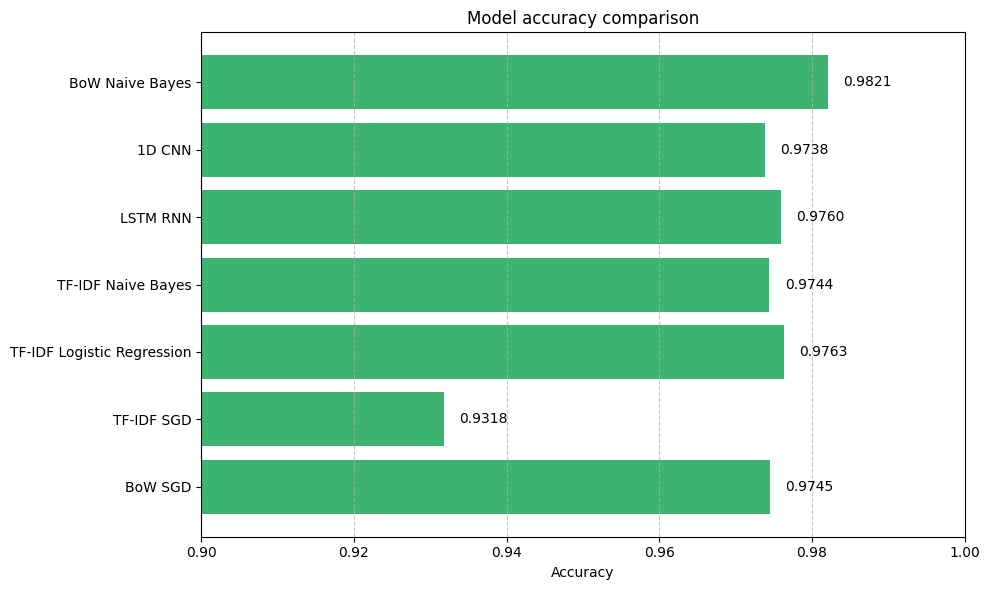

In [61]:
model_names = [
    "BoW Naive Bayes",
    "1D CNN",
    "LSTM RNN",
    "TF-IDF Naive Bayes",
    "TF-IDF Logistic Regression",
    "TF-IDF SGD",
    "BoW SGD"
]

accuracies = [
    0.9821010930265859,
    0.9738119103304536,
    0.9759677342370292,
    0.9744324057721986,
    0.9762859370276677,
    0.9317773216871112,
    0.9745437767489221
]


plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, accuracies, color='mediumseagreen')
plt.xlabel('Accuracy')
plt.title('Model accuracy comparison')
plt.xlim(0.90, 1.0)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see, the lowest accuracy was when we paired SGD with TF-IDF, and the highest one was Naive Bayes paired with BoW.

This makes BoW+Naive Bayes our choice for this part of the project - **language classification**.

In [65]:
import joblib
joblib.dump(modelNBBOW, "naive_bayes_bow_language_classification.pkl")

['naive_bayes_bow_language_classification.pkl']